In [10]:
import pandas as pd
import h2o
from h2o.estimators import H2ORandomForestEstimator

# Initialize H2O
h2o.init()

# Load the training data from "base_completa.csv"
train_data_path = "C:/Users/milen/OneDrive/Documentos/TCC/Bases/teste1.csv"
train_data = h2o.import_file(train_data_path)

# Load the test data from "teste.csv"
test_data_path = "C:/Users/milen/OneDrive/Documentos/TCC/Bases/teste2.csv"
test_df = pd.read_csv(test_data_path)

# Process Training Data
train_df = h2o.as_list(train_data)
train_df['Date'] = pd.to_datetime(train_df['Date'], unit='ms')
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day
train_df['Date'] = train_df['Date'].dt.strftime('%Y-%m-%d')
train_df['Diferenca_1_Dia'] = train_df['Preco_Real'].diff(periods=1)
train_df = train_df.dropna()  # Removing rows with NaN values after diff calculation

# Process Test Data (including sliding window)
test_df['Date'] = pd.to_datetime(test_df['Date'])
for lag in range(1, 4):  # Example for 3 days lag
    test_df[f'Preco_Real_Lag{lag}'] = test_df['Preco_Real'].shift(lag)
window_size = 1
test_df['Rolling_Mean_3d'] = test_df['Preco_Real'].rolling(window=window_size).mean()
test_df['Diferenca_1_Dia'] = test_df['Preco_Real'].diff(periods=1)
test_df.fillna(method='bfill', inplace=True)

# Convert the DataFrames back to H2O Frames
train_data = h2o.H2OFrame(train_df)
test_data = h2o.H2OFrame(test_df)

# Define the target variable and predictor variables
target_variable = 'Diferenca_1_Dia'
predictors = train_data.columns
predictors.remove(target_variable)

# Initialize and Train the GLM Model
glm_model = H2ORandomForestEstimator(model_id="rf_regressor.hex")
glm_model.train(x=predictors, y=target_variable, training_frame=train_data)

# Make predictions on the test set
predictions = glm_model.predict(test_data)

# Convert predictions to Pandas DataFrame
predictions_df = h2o.as_list(predictions)
predictions_df['Date'] = test_df['Date'].dt.strftime('%Y-%m-%d')
predictions_df['Diferenca_Pontos_Predita'] = predictions_df['predict']
predictions_df['Diferenca_Pontos_Real'] = test_df['Diferenca_1_Dia']

# Display the predictions along with actual differences
print(predictions_df[['Date', 'Diferenca_Pontos_Predita', 'Diferenca_Pontos_Real']])

# Display performance metrics
performance = glm_model.model_performance(test_data=test_data)
print("\nPerformance Metrics:")
print("MSE:", performance.mse())
print("RMSE:", performance.rmse())
print("MAE:", performance.mae())
print("R2:", performance.r2())


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 49 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_milen_o1cevs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.948 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\milen\AppData\Roaming\Python\Python310\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [Fator diario]
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\milen\AppData\Roaming\Python\Python310\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'Year': substituting in a column of NaN
  warnings.warn(w)
C:\Users\milen\AppData\Roaming\Python\Python310\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'Month': substituting in a column of NaN
  warnings.warn(w)
C:\Users\milen\AppData\Roaming\Python\Python310\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'Day': substituting in a column of NaN
  warnings.warn(w)


           Date  Diferenca_Pontos_Predita  Diferenca_Pontos_Real
0    2023-03-01                 -8.649808                   2.45
1    2023-03-02                 -8.330844                   2.45
2    2023-03-03                -10.947130                 -22.61
3    2023-03-06                 -6.238749                   9.53
4    2023-03-07                -11.423800                  10.10
..          ...                       ...                    ...
163  2023-10-24                 -2.825960                   4.38
164  2023-10-25                 -1.347760                 -25.06
165  2023-10-26                 -6.621800                  -3.07
166  2023-10-27                 -4.791667                  -6.19
167  2023-10-30                 -2.667400                  -4.67

[168 rows x 3 columns]

Performance Metrics:
MSE: 196.11494453821987
RMSE: 14.004104560385853
MAE: 10.768959947164385
R2: -0.24794652722693455


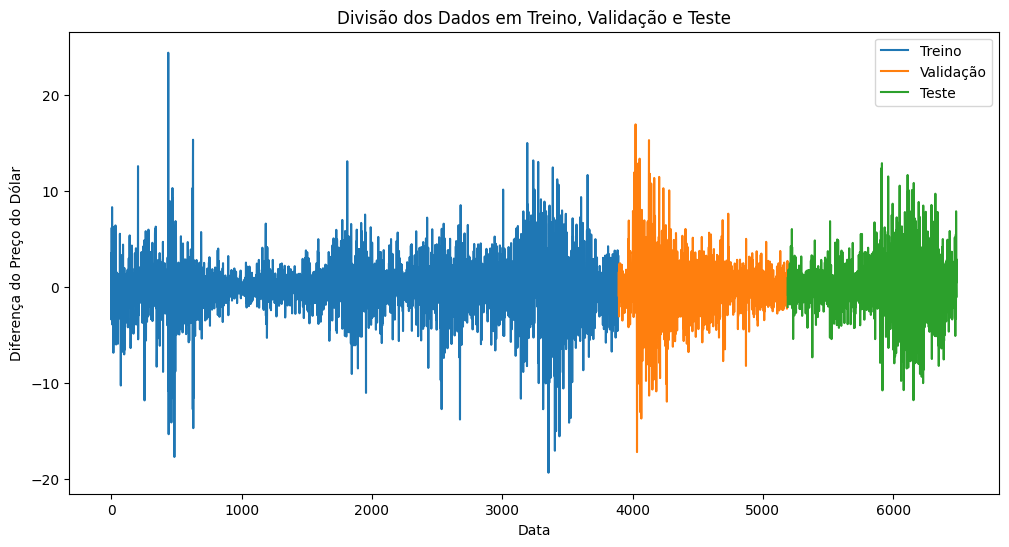

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregar e preparar dados
data = pd.read_csv('C:/Users/milen/OneDrive/Documentos/TCC/new/sem_clima.csv')
data['Data'] = pd.to_datetime(data['Data'])
data['Diff_Preco_Dolar'] = data['Preco_Dolar'].diff()
data = data.dropna()

# Definindo a variável alvo
target = data['Diff_Preco_Dolar']

# Divisão em treino, validação e teste
train_size = int(len(target) * 0.6)
val_size = int(len(target) * 0.2)
test_size = len(target) - train_size - val_size
train_data = target[:train_size]
val_data = target[train_size:train_size+val_size]
test_data = target[train_size+val_size:]

# Criação do gráfico
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Treino')
plt.plot(val_data.index, val_data, label='Validação')
plt.plot(test_data.index, test_data, label='Teste')
plt.title('Divisão dos Dados em Treino, Validação e Teste')
plt.xlabel('Data')
plt.ylabel('Diferença do Preço do Dólar')
plt.legend()
plt.show()
